In [4]:
import folium
import pickle
import pandas as pd
import networkx as nx
import numpy as np
from utils import linear_scaler

# Graph Analysis

Now that the graph is partially constructed, let's perform some analysis on it.

In [5]:
# Start by loading pickled data
G = pickle.load(open('data/processed/railgraph.pickle', 'rb'))
stop_id_to_name = pickle.load(open('data/processed/stop_id_to_name', 'rb'))
edges_counts = pd.read_pickle('data/processed/edges_counts.pickle', )
railway_stops = pd.read_pickle('data/processed/railway_stops.pickle')

## Betweenness Centrality

*TODO: add short description about centrality measure and how it can be interpreted* 

In [6]:
# Compute betweenness centrality of graph
btwn_centrality = nx.betweenness_centrality(G, weight = 'trains_count')

In [68]:
avg_btwn_centrality = np.mean(list(btwn_centrality.values()))
avg_btwn_centrality

0.007422074163181023

In [7]:
# Take top 20
btwn_centrality_20 = dict(sorted(btwn_centrality.items(), key=lambda item: - item[1])[:20]).keys()

print('Top 20 stops with the highest betweenness centrality:')
for stop in btwn_centrality_20:
    print('{:.<20} {:.4f}'.format(stop_id_to_name[stop], btwn_centrality[stop]))

Top 20 stops with the highest betweenness centrality:
Olten............... 0.4784
Brig................ 0.3920
Zürich HB........... 0.3376
Zollikofen.......... 0.2792
Basel SBB........... 0.2581
Münsingen........... 0.2480
Bellinzona.......... 0.2271
Nyon................ 0.1732
Sion................ 0.1688
Lausanne............ 0.1665
Bern................ 0.1608
Amriswil............ 0.1479
Sulgen.............. 0.1454
Weinfelden.......... 0.1441
Ostermundigen....... 0.1298
Romanshorn.......... 0.1279
Aigle............... 0.1223
St. Gallen.......... 0.1206
Montreux............ 0.1159
Flüelen............. 0.1130


We can see that the 20 most central nodes according to the betweenness centrality are mostly Swiss agglomerations. However, we see some less major cities with a somewhat important centrality: i.e. Visp, Landquart, Ins. These are probably smalles cities through which has to pass because of their geographic localisation: i.e. the stop might be on the intersection of multiple lines for example. 

In [8]:
for node in G.nodes:
    G.nodes[node]['centrality'] = btwn_centrality[node]

In [9]:
def scaler(min_, max_, lower, upper):
    return lambda x: (((x - min_) * (upper - lower)) / (max_ - min_)) + lower

btwn_scaler = scaler(min(btwn_centrality.values()), max(btwn_centrality.values()), 1, 10)

In [10]:
m = folium.Map(location=[46.771413, 8.471689], zoom_start = 8, tiles='CartoDB Positron', height = '80%')

# Draw nodes
for node in G.nodes():
    lat, lon = G.nodes[node]['lat'], G.nodes[node]['lon']
    folium.CircleMarker(
        location = [lat, lon],
        popup = '{}\nCentrality: {:.2f}'.format(G.nodes[node]['name'],  G.nodes[node]['centrality']), 
        radius = btwn_scaler(G.nodes[node]['centrality']),
        fill = True,
        color = 'green' if node in btwn_centrality_20 else '#3388ff',
        opacity = 1 if node in btwn_centrality_20 else 0.3,
    ).add_to(m)

m.save("network_betweenness.html")
m

In [23]:
i=0
for g in nx.connected_components(G):
    i+=1
i

13

In [ ]:
nx.average_shortest_path_length(G)

In [59]:
avg_clust = nx.average_clustering(G, weight='train_count')

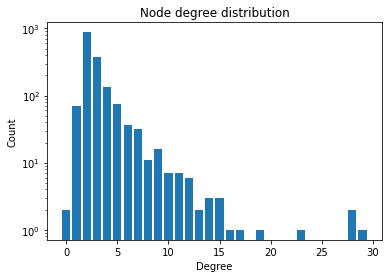

In [70]:
import matplotlib.pyplot as plt
hist = nx.degree_histogram(G)
plt.bar(range(len(hist)), hist)
plt.title('Node degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.yscale('log')
plt.savefig('./docs/degree_dist.png')
plt.show()

In [26]:
degs = []
for i,nb in enumerate(hist):
    degs.extend([i]*nb)
degs = pd.Series(degs)

degs.describe()

count    1663.000000
mean        3.023452
std         2.262828
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        29.000000
dtype: float64

In [55]:
avg_deg = degs.mean()

In [56]:
from geopy.distance import distance
for edge in G.edges:
    node_0, node_1 = G.nodes[edge[0]], G.nodes[edge[1]]
    G.edges[edge[0],edge[1]]['length'] = distance((node_0['lat'], node_0['lon']), (node_1['lat'], node_1['lon'])).km

closeness = nx.closeness_centrality(G, distance='length')
avg_closeness = np.mean(list(closeness.values()))

In [54]:
global_eff = nx.global_efficiency(G)

In [64]:
output = pd.Series(name='Network Properties',data={
    'efficiency': global_eff,
    'closeness_centrality': avg_closeness,
    'average_degree': avg_deg,
    'average_cluster': avg_clust
}).to_markdown()

with open('temp.txt', 'w') as f:
    f.write(output)

In [69]:
nx.degree_assortativity_coefficient(G)

0.2814626257655887

In [71]:
nx.number_of_edges(G)

2514

In [72]:
nx.number_of_nodes(G)

1663

In [74]:
nx.degree(G, weight='train_count')

DegreeView({'8503000': 29, '8507000': 28, '8500010': 16, '8506000': 15, '8505000': 23, '8501120': 19, '8503006': 12, '8500218': 28, '8503003': 9, '8501008': 14, '8503016': 7, '8503020': 7, '8504300': 15, '8506302': 15, '8502204': 10, '8502113': 14, '8503001': 9, '8507100': 12, '8503504': 7, '8504221': 9, '8503123': 6, '8509000': 12, '8503125': 5, '8502119': 11, '8503147': 4, '8503110': 6, '8501200': 11, '8501605': 8, '8500309': 12, '8503508': 9, '8504100': 9, '8503424': 9, '8501118': 9, '8503202': 10, '8500023': 9, '8503206': 8, '8503305': 6, '8501037': 11, '8504200': 10, '8501609': 7, '8505300': 12, '8500207': 13, '8508005': 11, '8505213': 10, '8501030': 9, '8501026': 2, '8501300': 13, '8503209': 14, '8503010': 5, '8506105': 8, '8502202': 10, '8505004': 17, '8509002': 9, '8503400': 7, '8503129': 4, '8502007': 7, '8503509': 3, '8508100': 5, '8501506': 9, '8503011': 4, '8507492': 7, '8509411': 9, '8504414': 7, '8506121': 7, '8506100': 6, '8503127': 2, '8503121': 4, '8503225': 11, '85020